In [10]:
# Demonstration of Convolution-based Simulation 
# Contact: Michael Pyrcz, University of Texas at Austin, Geostatistics Course  (Twitter: @GeostatsGuy) 
#
# Steps:
# 1. Make a kernel.  For this example we parameterize a simple 3 point symmetric kernel.  The default
#    is a triangular kernel with variable width.
# 2. Assign a random standard normal value to each model location (model is a 1D vector with 'nx' cells)
# 3. Convolve the random array from 2. with the kernel designed in 1.
# 4. Affine correction to standardize the convolution to have a mean of 0.0 and standard deviation of 1.0.
# 5. Calculate the vairogram of the standardized convolution to confirm the presence and form of spatial correlation.
#
# Efron, 1982, The jackknife, the bootstrap, and other resampling plans, Society of Industrial and Applied Math, 
# CBMS-NSF Monographs, 38.

In [11]:
# Imports 
import scipy
import numpy as np
import pandas as pd
import math
import random as rand
import matplotlib.pyplot as plt
import statsmodels as sm

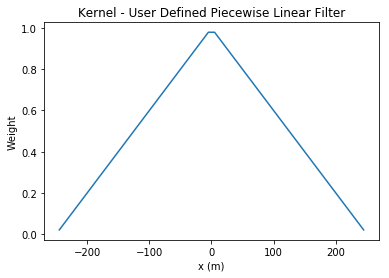

In [12]:
# 1. Make a Kernel with User Specified Width and Shape

# User Specified Parameters
#-----------------------------
xsiz = 10                     # cell size
kernel_half_width = 250.0     # extend of filter in half width
kernel_edge_height = 0.0      # value of the filter at the edge
kernel_center_height = 1.0    # value of the filter in the middle
#-----------------------------

# Simple 3 point symmetric piecewise linear filter
x = np.zeros(3); y = np.zeros(3)
x[0] = -1.0 * kernel_half_width; x[1] =  0.0; x[2] = 1.0 * kernel_half_width
y[0] = kernel_edge_height; y[1] = kernel_center_height; y[2] = kernel_edge_height

# Axis for the filter
nkernel = round((kernel_half_width*2.0)/xsiz)
xkernel_array = np.zeros(nkernel)
farray = np.zeros(nkernel)
xmn = -1.0*round(nkernel/2.0)*xsiz + xsiz*0.5
for ikernel in range(0, nkernel):
    x_value = xmn + ikernel * xsiz
    xkernel_array[ikernel] = x_value
    
# Filter with linear interpolation method   
akernel = np.interp(xkernel_array,x,y)

#Plot filter
#plt.clf()
fig_kernel = plt.figure(); ax = plt.axes()
ax.plot(xkernel_array, akernel);
plt.title("Kernel - User Defined Piecewise Linear Filter"); plt.xlabel("x (m)"); plt.ylabel("Weight"); plt.show()    
    

Random N[0,1] Mean =  0.011677337961035704
Random N[0,1] Standard Deviation =  0.9807495297909122


<Figure size 432x288 with 0 Axes>

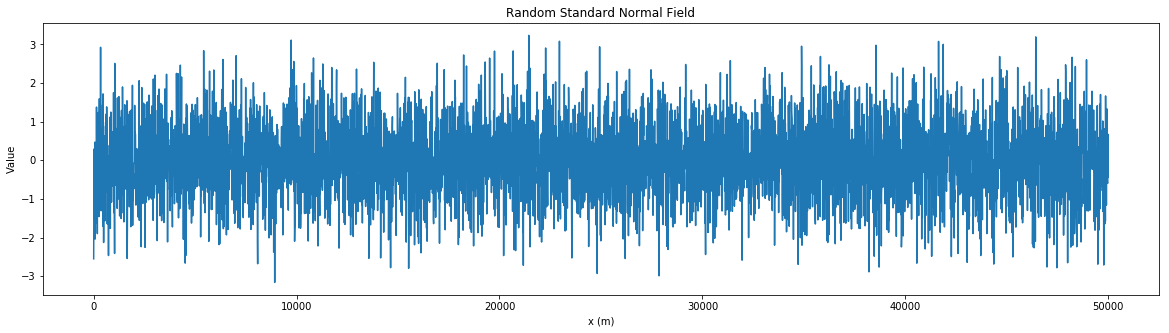

In [13]:
#2. Assign a random standard normal value to each location in the 1D model of size nx 

# User Specified Parameters
#-----------------------------
nx = 5000                     # model size in number of cells                   
#-----------------------------

# Axis for the model   
xmodel_array = np.zeros(nx)
xmodel_mn = xsiz*0.5 
for ix in range(0, nx):
    x_value = xmodel_mn + ix * xsiz
    xmodel_array[ix] = x_value

# Assign random standard normal values 
random_array = np.random.normal(0.0,1.0,nx)

random_mean = np.mean(random_array)
random_std = np.std(random_array)
print('Random N[0,1] Mean = ', random_mean)
print('Random N[0,1] Standard Deviation = ', random_std)

# Plot the random array
plt.clf()
fig_random_normal = plt.figure(figsize=(20,5)); ax = plt.axes()
ax.plot(xmodel_array,random_array);
plt.title("Random Standard Normal Field"); plt.xlabel("x (m)"); plt.ylabel("Value");
plt.show()


Initial Mean =  0.30937359966522715
Initial Standard Deviation =  4.258470201191333


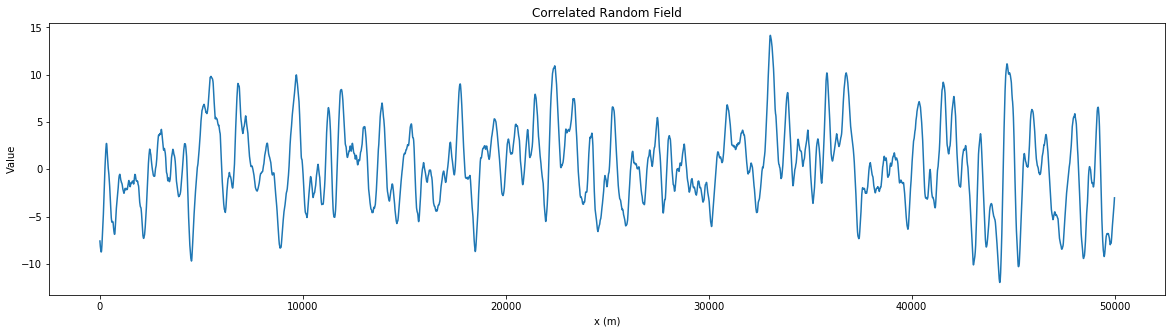

In [14]:
#3. Convolve the vector of random standard normal values with the filter

model_array = np.convolve(random_array,akernel,'same')

initial_mean = np.mean(model_array); initial_std = np.std(model_array)
print('Initial Mean = ', initial_mean); print('Initial Standard Deviation = ', initial_std)

fig_model = plt.figure(figsize=(20,5)); ax = plt.axes()
ax.plot(xmodel_array,model_array);
plt.title("Correlated Random Field"); plt.xlabel("x (m)");plt.ylabel("Value");
plt.show()

Normalized Mean =  1.7053025658242403e-17
Normalized Standard Deviation =  1.0


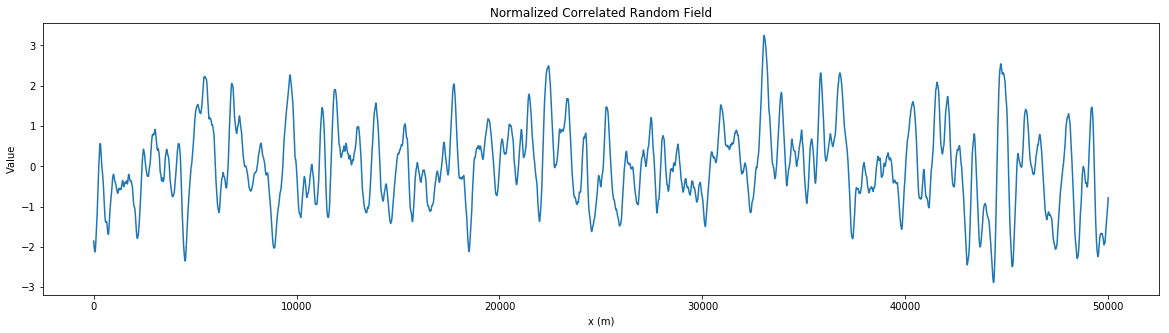

In [15]:
#4. Affine correction of the convolution 

norm_model_array = np.zeros(nx)
for ix in range(0, nx):
    norm_model_array[ix] = (1.0 / initial_std)*(model_array[ix]-initial_mean)
  
norm_mean = np.mean(norm_model_array); norm_std = np.std(norm_model_array)
print('Normalized Mean = ', norm_mean); print('Normalized Standard Deviation = ', norm_std)

fig_norm_model = plt.figure(figsize=(20,5)); ax = plt.axes()
ax.plot(xmodel_array,norm_model_array);
plt.title("Normalized Correlated Random Field"); plt.xlabel("x (m)");plt.ylabel("Value");
plt.show()


Approximate Range (Earliest Approach of the Sill) =  360.0
Filter Width =  500.0


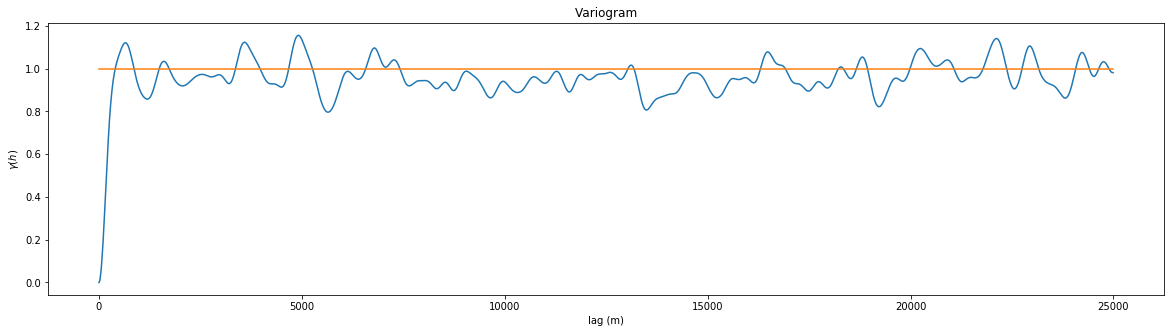

In [16]:
# 5. Calculate and plot the vairogram for the normalized correlated random field
    
nlags = int(nx*0.5)

pairs = np.zeros(nlags)
variogram = np.zeros(nlags)
lags = np.zeros(nlags)

for ilags in range(0, nlags):
    pairs[ilags] = 0
    variogram[ilags] = 0

for itail in range(0, nx):
    for ihead in range(itail,nx):
        ilag = ihead - itail
        if ilag < nlags:
            variogram[ilag] = variogram[ilag] + (norm_model_array[ihead] - norm_model_array[itail])**2.0
            pairs[ilag] = pairs[ilag] + 1.0
 
approx_range = 0.0
for ilags in range(0, nlags):
    lags[ilags] = ilags * xsiz
    variogram[ilags] = variogram[ilags] / (2.0*pairs[ilags])
    
for ilags in range(0, nlags):
    if variogram[ilags] > 0.95:
        approx_range = lags[ilags]
        break

print("Approximate Range (Earliest Approach of the Sill) = ", approx_range)
print("Filter Width = ", kernel_half_width*2.0)

fig_var_func = plt.figure(figsize=(20,5)); ax = plt.axes()
ax.plot(lags,variogram); ax.plot([0,25000],[1.0,1.0])
plt.title("Variogram"); plt.xlabel("lag (m)");plt.ylabel(r'$\gamma(h)$');
plt.show()


In [17]:
# What did we learn?
# 1. It is possible to calculate an unconditional spatially correlated random function from a random (N[0,1]) vector  
#    convolved with a filter window.  In simplier terms applying moving window average (with a weighting function over 
#    the window).
# 2. The shape of the resulting experimental variogram depends on the shape of the filter.  For a triangular filter the 
#    resulting experimental has a 1D spherical equivalent shape.  
# 3. The range is the width of the filter, since no information is shared at lag distances wider than the filter.
#
# References:
#
# Yarlagadda, R.K.R., 2010, Analog and digital signals and systems, Springer, 540 p.
#